# Проект -  Прогнозирование оттока клиентов телеком компании

Требуется построить систему, способную проанализировать поведение клиентов телеком компании и спрогнозировать, откажется ли клиент от продуктов компании в ближайшее время или нет. В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с компанией.

**Цель проекта:** изучить поведение клиентов, и на основе этого представить систему, позволяющую спрогнозировать отказ клиента от услуг компании.

**Ход исследования:** проведем ознакомительный обзор данных, о качестве полученного датасета ничего не известно, поэтому возможно потребуется предобработка. Изучим данные, проведем анализ различных групп клиентов, оценим влияние различных факторов на будущий уход клиента, построим модели, выберем метрику и произведем оценку их качества, и выберем оптимальную модель. Таким образом исследование пройдет в несколько этапов:

1. Загрузка данных
2. Подготовка данных
3. Сравнительный анализ выборок клиентов
4. Оценка важности разлчиных факторов на уход клиента
5. Обучение и оценка качества моделей
6. Проверка модели

# Импорт библиотек и загрузка данных

In [67]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool

from sklearn.model_selection import train_test_split

In [76]:
data = pd.read_csv('churn_dataset.csv')
data.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


# Знакомство с данными

Посмотрим на общую информацию о датасете

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

В полученном датасете 100 параметров и 100000 записей. Как можно заметить в данных присутствуют пропуски, потребуется предобработка

**Описание данных**

- `rev_Mean`: Среднемесячный доход (сумма начислений)
- `mou_Mean`: Среднее количество минут использования в месяц
- `totmrc_Mean`: Средняя сумма ежемесячных регулярных платежей
- `da_Mean`: Среднее количество вызовов с помощью справочника
- `ovrmou_Mean`: Среднее превышение минут использования
- `ovrrev_Mean`: Средний сверхдоход
- `vceovr_Mean`: Средний доход от перерасхода голосовых услуг
- `datovr_Mean`: Средний доход от избыточного трафика
- `roam_Mean`: Среднее количество звонков в роуминге
- `change_mou`: Процентное изменение количества минут использования в месяц по сравнению со средним показателем за предыдущие три месяца
- `change_rev`: Процентное изменение месячного дохода по сравнению со средним показателем за предыдущие три месяца
- `drop_vce_Mean`: Среднее количество сброшенных (неудачных) голосовых вызовов
- `drop_dat_Mean`: Среднее количество потерянных (неудачных) вызовов данных
- `blck_vce_Mean`: Среднее количество заблокированных (неудачных) голосовых вызовов
- `blck_dat_Mean`: Среднее количество заблокированных (неудачных) вызовов данных
- `unan_vce_Mean`: Среднее количество неотвеченных голосовых вызовов
- `unan_dat_Mean`: Среднее количество вызовов данных без ответа
- `plcd_vce_Mean`: Среднее количество попыток совершения голосовых вызовов
- `plcd_dat_Mean`: Среднее количество попыток передачи данных
- `recv_vce_Mean`: Среднее количество принятых голосовых вызовов
- `recv_sms_Mean`: N
- `comp_vce_Mean`: Среднее количество завершенных голосовых вызовов
- `comp_dat_Mean`: Среднее количество завершенных вызовов данных
- `custcare_Mean`: Среднее количество обращений в службу поддержки
- `ccrndmou_Mean`: Среднее округленное количество минут использования обращений в службу поддержки клиентов
- `cc_mou_Mean`: Среднее неокругленное количество звонков в службу поддержки клиентов (см. CUSTCARE_MEAN) в минутах
- `inonemin_Mean`: Среднее количество входящих звонков менее одной минуты
- `threeway_Mean`: Среднее количество трехсторонних вызовов
- `mou_cvce_Mean`: Среднее неокругленное количество минут использования завершенных голосовых вызовов
- `mou_cdat_Mean`: Среднее неокругленное количество минут использования завершенных вызовов данных
- `mou_rvce_Mean`: Среднее неокругленное количество минут использования полученных голосовых вызовов
- `owylis_vce_Mean`: Среднее количество исходящих голосовых вызовов с беспроводной сети на беспроводную
- `mouowylisv_Mean`: Среднее неокругленное количество минут использования исходящих беспроводных голосовых вызовов на беспроводные
- `iwylis_vce_Mean`: N
- `mouiwylisv_Mean`: Среднее неокругленное количество минут использования входящих беспроводных и беспроводных голосовых вызовов
- `peak_vce_Mean`: Среднее количество входящих и исходящих голосовых вызовов с пиковой нагрузкой
- `peak_dat_Mean`: Среднее количество пиковых вызовов данных
- `mou_peav_Mean`: Среднее неокругленное количество минут использования пиковых голосовых вызовов
- `mou_pead_Mean`: Среднее неокругленное количество минут использования пиковых вызовов данных
- `opk_vce_Mean`: Среднее количество голосовых вызовов в непиковое время
- `opk_dat_Mean`: Среднее количество вызовов данных в непиковое время
- `mou_opkv_Mean`: Среднее неокругленное количество минут использования голосовых вызовов в непиковое время
- `mou_opkd_Mean`: Среднее неокругленное количество минут использования данных в непиковые часы
- `drop_blk_Mean`: Среднее количество сброшенных или заблокированных вызовов
- `attempt_Mean`: Среднее количество попыток звонков
- `complete_Mean`: Среднее количество завершенных звонков
- `callfwdv_Mean`: Среднее количество звонков с переадресацией
- `callwait_Mean`: Среднее количество ожидающих вызовов
- `churn`: Случай оттока между 31-60 днями после даты наблюдения
- `months`: Общее количество месяцев службы
- `uniqsubs`: Количество уникальных подписчиков в семье
- `actvsubs`: Количество активных абонентов в домохозяйстве
- `new_cell`: Новый пользователь сотового телефона
- `crclscod`: Код кредитного класса
- `asl_flag`: Лимит расходов аккаунта
- `totcalls`: Общее количество обращений за жизнь клиента
- `totmou`: Общее количество минут использования в течение жизни клиента
- `totrev`: Общий доход
- `adjrev`: Выставление скорректированных счетов за общий доход за все время существования клиента
- `adjmou`: Скорректированное выставление счетов общее количество минут использования в течение жизни клиента
- `adjqty`: Скорректированное биллингом общее количество звонков за время жизни клиента
- `avgrev`: Среднемесячный доход в течение жизни клиента
- `avgmou`: Среднемесячное количество минут использования в течение жизни клиента
- `avgqty`: Среднемесячное количество звонков в течение жизни клиента
- `avg3mou`: Среднемесячное количество минут использования за предыдущие три месяца
- `avg3qty`: Среднемесячное количество звонков за предыдущие три месяца
- `avg3rev`: Среднемесячный доход за предыдущие три месяца
- `avg6mou`: Среднемесячное количество минут использования за предыдущие шесть месяцев
- `avg6qty`: Среднемесячное количество звонков за предыдущие шесть месяцев
- `avg6rev`: Среднемесячный доход за предыдущие шесть месяцев
- `prizm_social_one`: Только письмо социальной группы
- `area`: Географический район
- `dualband`: Двухполосный
- `refurb_new`: Телефон: восстановленный или новый
- `hnd_price`: Текущая цена телефона
- `phones`: Количество выпущенных телефонов
- `models`: Количество выпущенных моделей
- `hnd_webcap`: Веб-возможности телефона
- `truck`: Индикатор грузовика
- `rv`: Индикатор RV
- `ownrent`: Статус владельца/арендатора дома
- `lor`: Продолжительность проживания
- `dwlltype`: Тип жилого помещения
- `marital`: Семейный статус
- `adults`: Количество взрослых в домохозяйстве
- `infobase`: совпадение информационной базы
- `income`: Расчетный доход
- `numbcars`: Известное количество автомобилей
- `HHstatin`: Индикатор статуса главного домохозяйства
- `dwllsize`: Размер жилья
- `forgntvl`: Фиктивная переменная для поездок за границу
- `ethnic`: Сводный код этнической принадлежности
- `kid0_2`: Ребенок 0-2 лет в семье
- `kid3_5`: Ребенок 3-5 лет в семье
- `kid6_10`: Ребенок 6-10 лет в семье
- `kid11_15`: Ребенок 11-15 лет в семье
- `kid16_17`: Ребенок 16-17 лет в семье
- `creditcd`: Индикатор кредитной карты
- `eqpdays`: Количество дней (возраст) текущего оборудования
- `Customer_ID`: N

Как можно заметить по описанию выше, имеющиеся данные можно сгруппировать согласно следующим факторам:

* **Данные о поведении клиента:** различные статистики использования предоставляемых услуг
* **Данные о личностных характеристиках клиента:** различная информация, позволяющая лучше охарактеризовать клиента с различных сторон


Чтобы решить поставленную задачу, первый вопрос, на который необходимо ответить, - почему клиенты уходят? 

1) Первой причиной, как я полагаю, является ответ подавляющего большинства ушедших клиентов: «услуги, предоставляемые телекоммуникационной компанией, меня не удовлетворяют». Это ответ с точки зрения продуктов компании. 

2) Вторая причина заключается в том, что клиенты теряются из-за изменения их личных обстоятельств, например, старости. Это ответ с точки зрения изменения личных качеств.

Второй вопрос, на который нужно ответить: какое поведение указывает на то, что клиенты склонны к оттоку? За поведенческими характеристиками часто стоит отношение клиента к компании и продукту, которое отражает некоторые атрибуты ярлыка клиента, такие как лояльность пользователя, активность пользователя и т.д.

In [77]:
data.drop(["Customer_ID"], axis = 1, inplace=True)

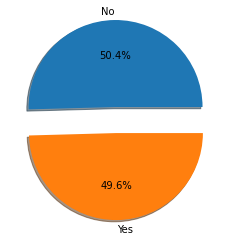

In [52]:
plt.pie(np.array(data['churn'].value_counts()),
        labels = ['No', 'Yes'],
        explode=[0.3, 0],
        autopct='%1.1f%%',
        shadow=True)
plt.show()

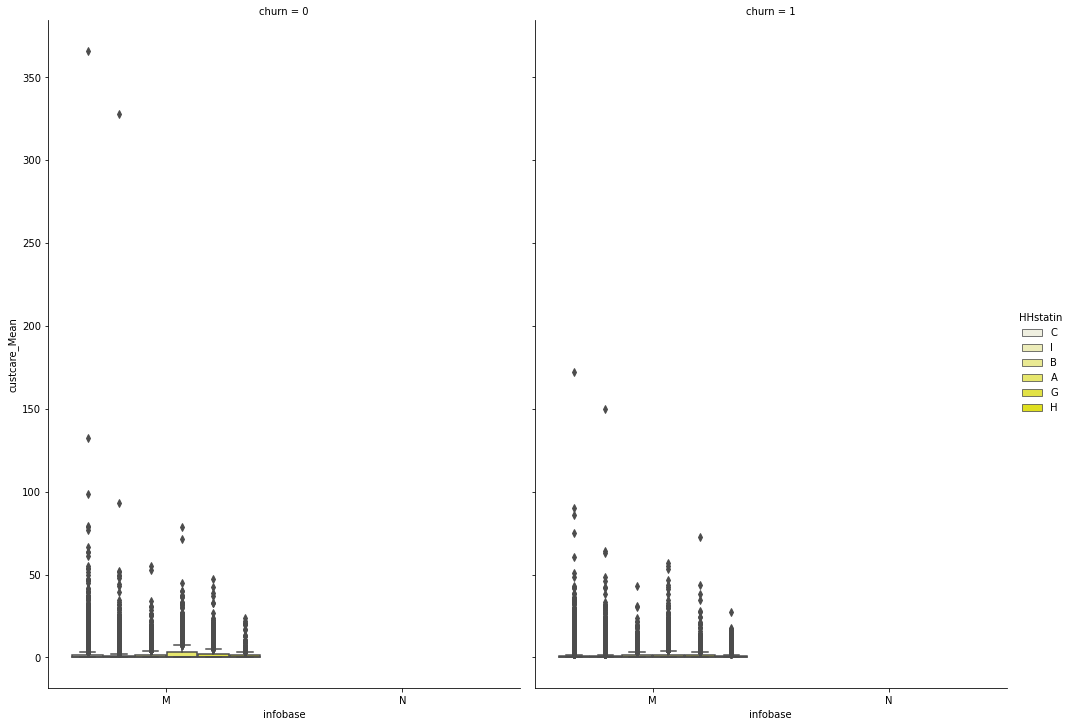

In [53]:
sns.catplot(x="infobase", y="custcare_Mean", hue="HHstatin", col="churn", data=data, color = "yellow",kind="box", height=10, aspect=.7);

<AxesSubplot:>

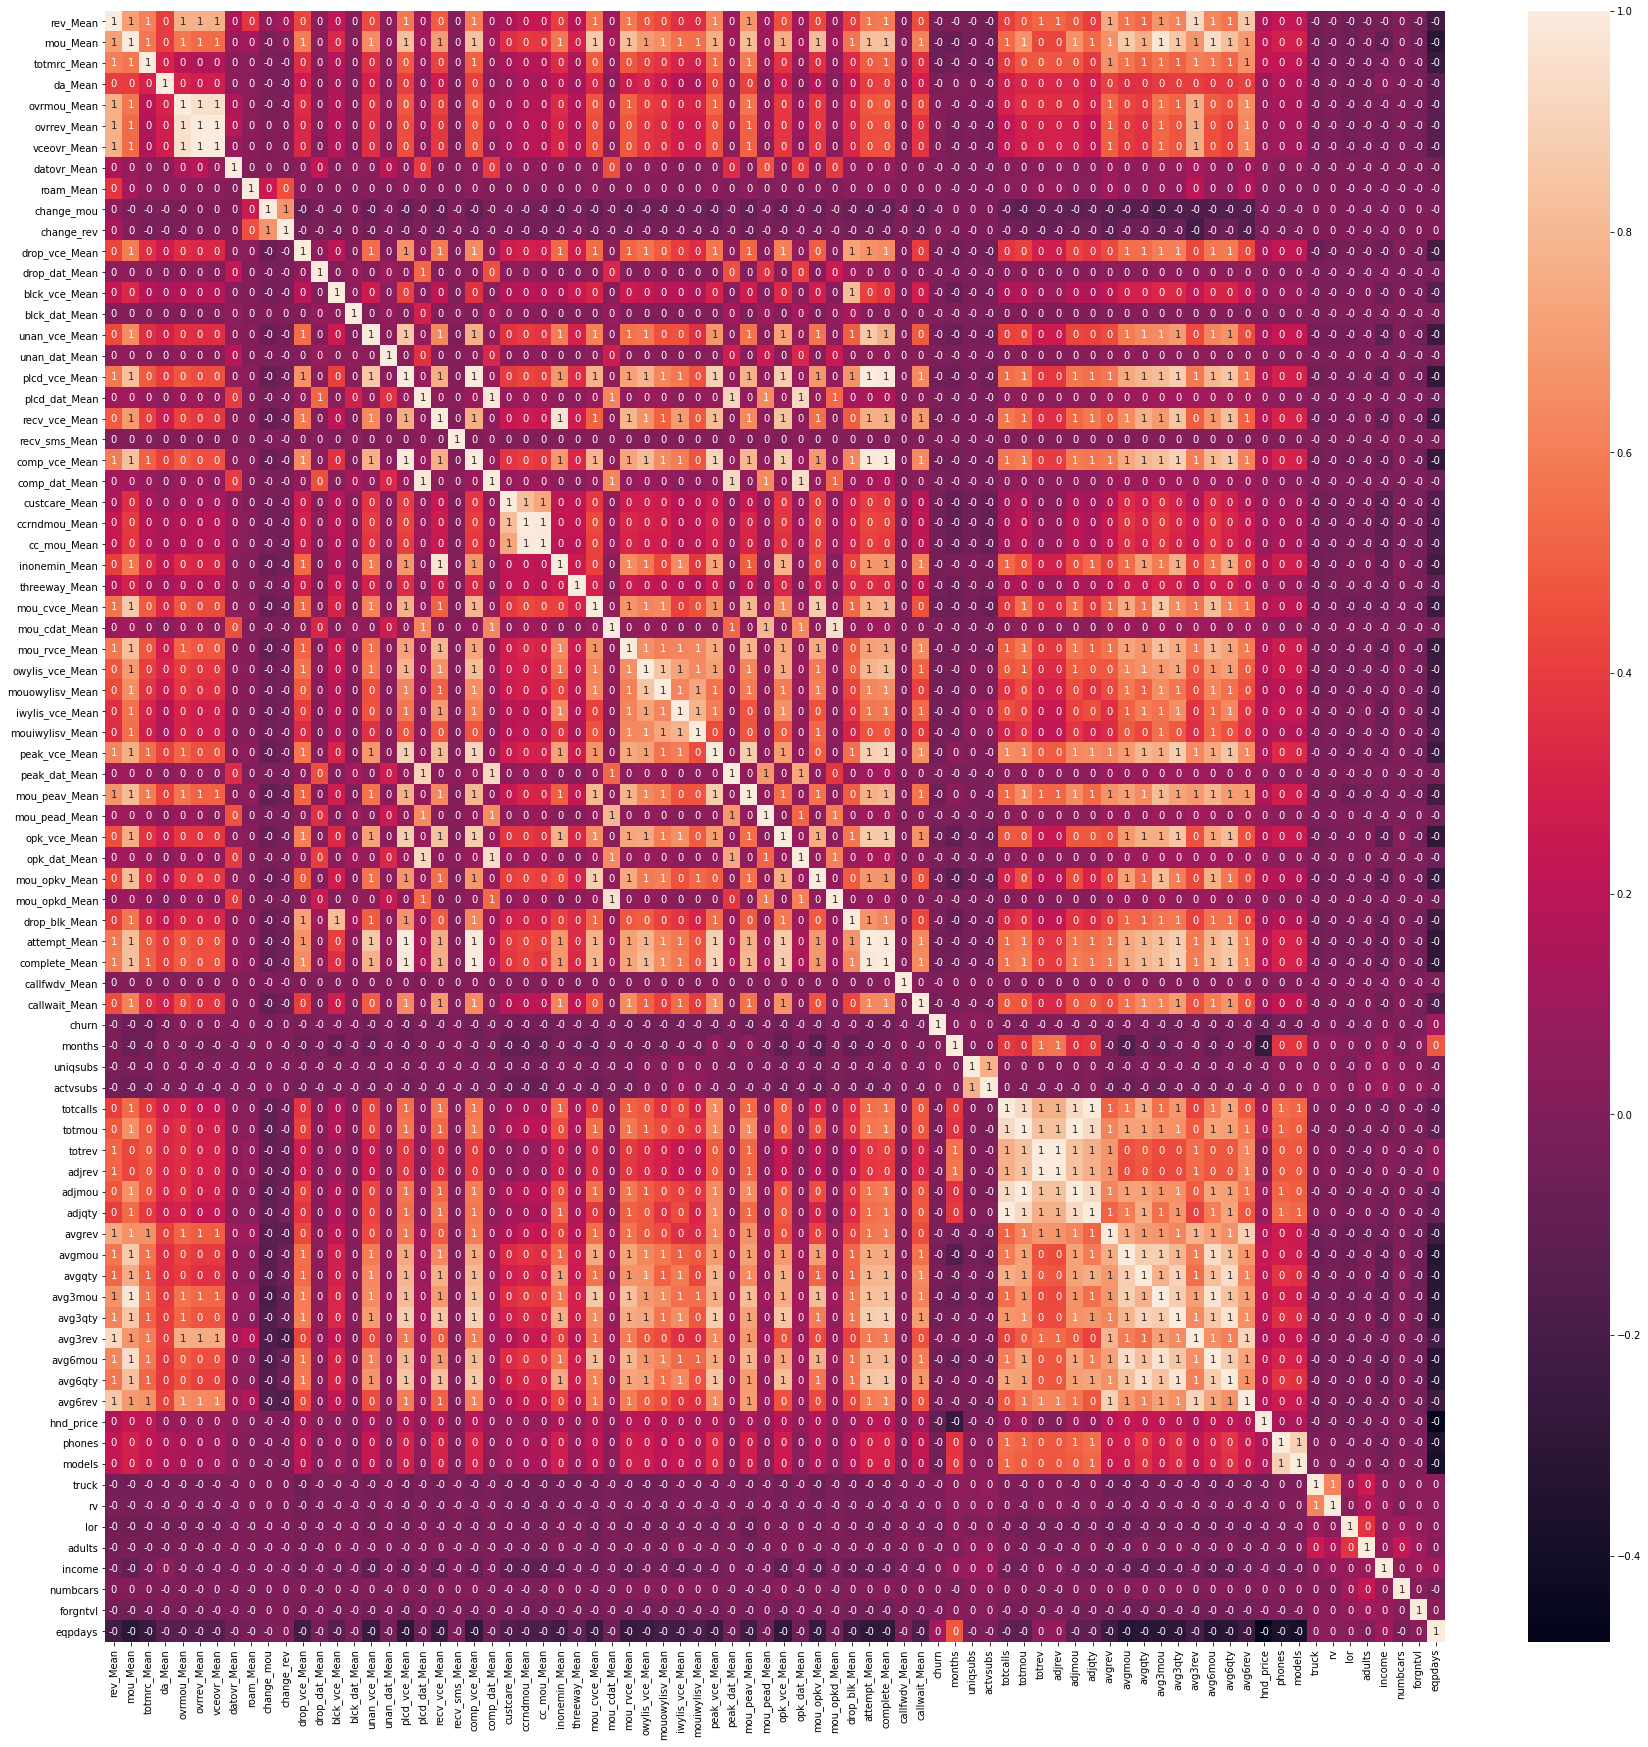

In [54]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(data.corr(), annot=True, fmt='.0f')

In [55]:
data.describe(include=['O'])

,new_cell,crclscod,asl_flag,prizm_social_one,area,dualband,refurb_new,hnd_webcap,ownrent,dwlltype,...,infobase,HHstatin,dwllsize,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
count,100000,100000,100000,92612,99960,99999,99999,89811,66294,68091,...,77921,62077,61692,98268,98268,98268,98268,98268,98268,98268
unique,3,54,2,5,19,4,2,3,2,2,...,2,6,15,17,2,2,2,2,2,2
top,U,AA,N,S,NEW YORK CITY AREA,Y,N,WCMB,O,S,...,M,C,A,N,U,U,U,U,U,Y
freq,66914,36509,86064,32097,11098,72265,85593,75733,64284,48759,...,77697,39124,47205,33389,94256,93572,90195,89454,88304,67234


# Предобработка данных

Оценим качество полученных данных

In [56]:
# Проверим датасет на наличие дубликатов
data.duplicated().sum()

0

In [57]:
# Посмотрим на пропуски в датасете
data.isna().sum().sort_values(ascending = False).head(25)

numbcars            49366
dwllsize            38308
HHstatin            37923
ownrent             33706
dwlltype            31909
lor                 30190
income              25436
adults              23019
infobase            22079
hnd_webcap          10189
prizm_social_one     7388
avg6qty              2839
avg6rev              2839
avg6mou              2839
kid6_10              1732
kid16_17             1732
rv                   1732
kid3_5               1732
marital              1732
creditcd             1732
kid11_15             1732
forgntvl             1732
ethnic               1732
kid0_2               1732
truck                1732
dtype: int64

В данных присутствует значительное количествово пропусков, визуализируем их

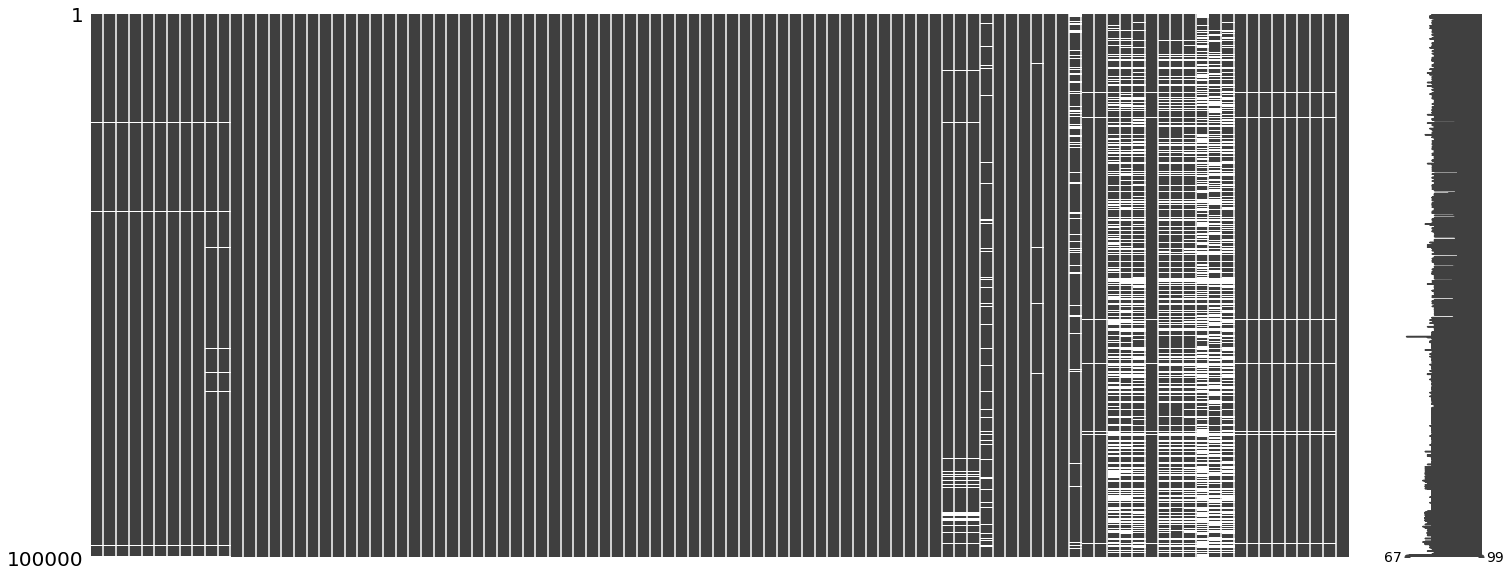

In [58]:
# Визуализируем пропуски
msno.matrix(data);

In [35]:
#data['numbcars']=data['numbcars'].fillna(0)

In [59]:
data.drop(['numbcars', 'dwllsize','HHstatin','ownrent','dwlltype','lor','income','adults','prizm_social_one','infobase','crclscod'],axis=1,inplace=True)

In [60]:
data['hnd_webcap']=data['hnd_webcap'].fillna('UNKW')

data['avg6qty']=data['avg6qty'].fillna(data['avg6qty'].mean())
data['avg6rev']=data['avg6rev'].fillna(data['avg6rev'].mean())
data['avg6mou']=data['avg6mou'].fillna(data['avg6mou'].mean())

data['change_mou']=data['change_mou'].fillna(data['change_mou'].mean())
data['change_rev']=data['change_rev'].fillna(data['change_rev'].mean())

data['rev_Mean']=data['rev_Mean'].fillna(data['rev_Mean'].mean())
data['totmrc_Mean']=data['totmrc_Mean'].fillna(data['totmrc_Mean'].mean())
data['da_Mean']=data['da_Mean'].fillna(data['da_Mean'].mean())
data['ovrmou_Mean']=data['ovrmou_Mean'].fillna(data['ovrmou_Mean'].mean())
data['ovrrev_Mean']=data['ovrrev_Mean'].fillna(data['ovrrev_Mean'].mean())
data['vceovr_Mean']=data['vceovr_Mean'].fillna(data['vceovr_Mean'].mean())
data['datovr_Mean']=data['datovr_Mean'].fillna(data['datovr_Mean'].mean())
data['roam_Mean']=data['roam_Mean'].fillna(data['roam_Mean'].mean())
data['mou_Mean']=data['mou_Mean'].fillna(data['mou_Mean'].mean())

In [70]:
data.dropna(inplace=True)

In [71]:
X = data.drop(['churn'], axis=1)
y = data['churn']

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      train_size=0.75,
                                                      random_state=1)

In [73]:
cat_col = data.select_dtypes(include = 'object').columns
cat_col = list(cat_col)
cat_col

['new_cell',
 'crclscod',
 'asl_flag',
 'prizm_social_one',
 'area',
 'dualband',
 'refurb_new',
 'hnd_webcap',
 'ownrent',
 'dwlltype',
 'marital',
 'infobase',
 'HHstatin',
 'dwllsize',
 'ethnic',
 'kid0_2',
 'kid3_5',
 'kid6_10',
 'kid11_15',
 'kid16_17',
 'creditcd']

In [74]:
best_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_seed=1,
    use_best_model=True,
    custom_loss=['AUC'],
    early_stopping_rounds=150
)

In [75]:
best_model.fit(
    X_train, y_train,
    cat_features=cat_col,
    eval_set=(X_valid, y_valid),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.6930400363 - 0.6943020

In [83]:
num_cols = data.select_dtypes(include = ['float64', 'int64']).columns
num_cols = list(num_cols)
len(num_cols)

78

IndexError: index 5 is out of bounds for axis 0 with size 5

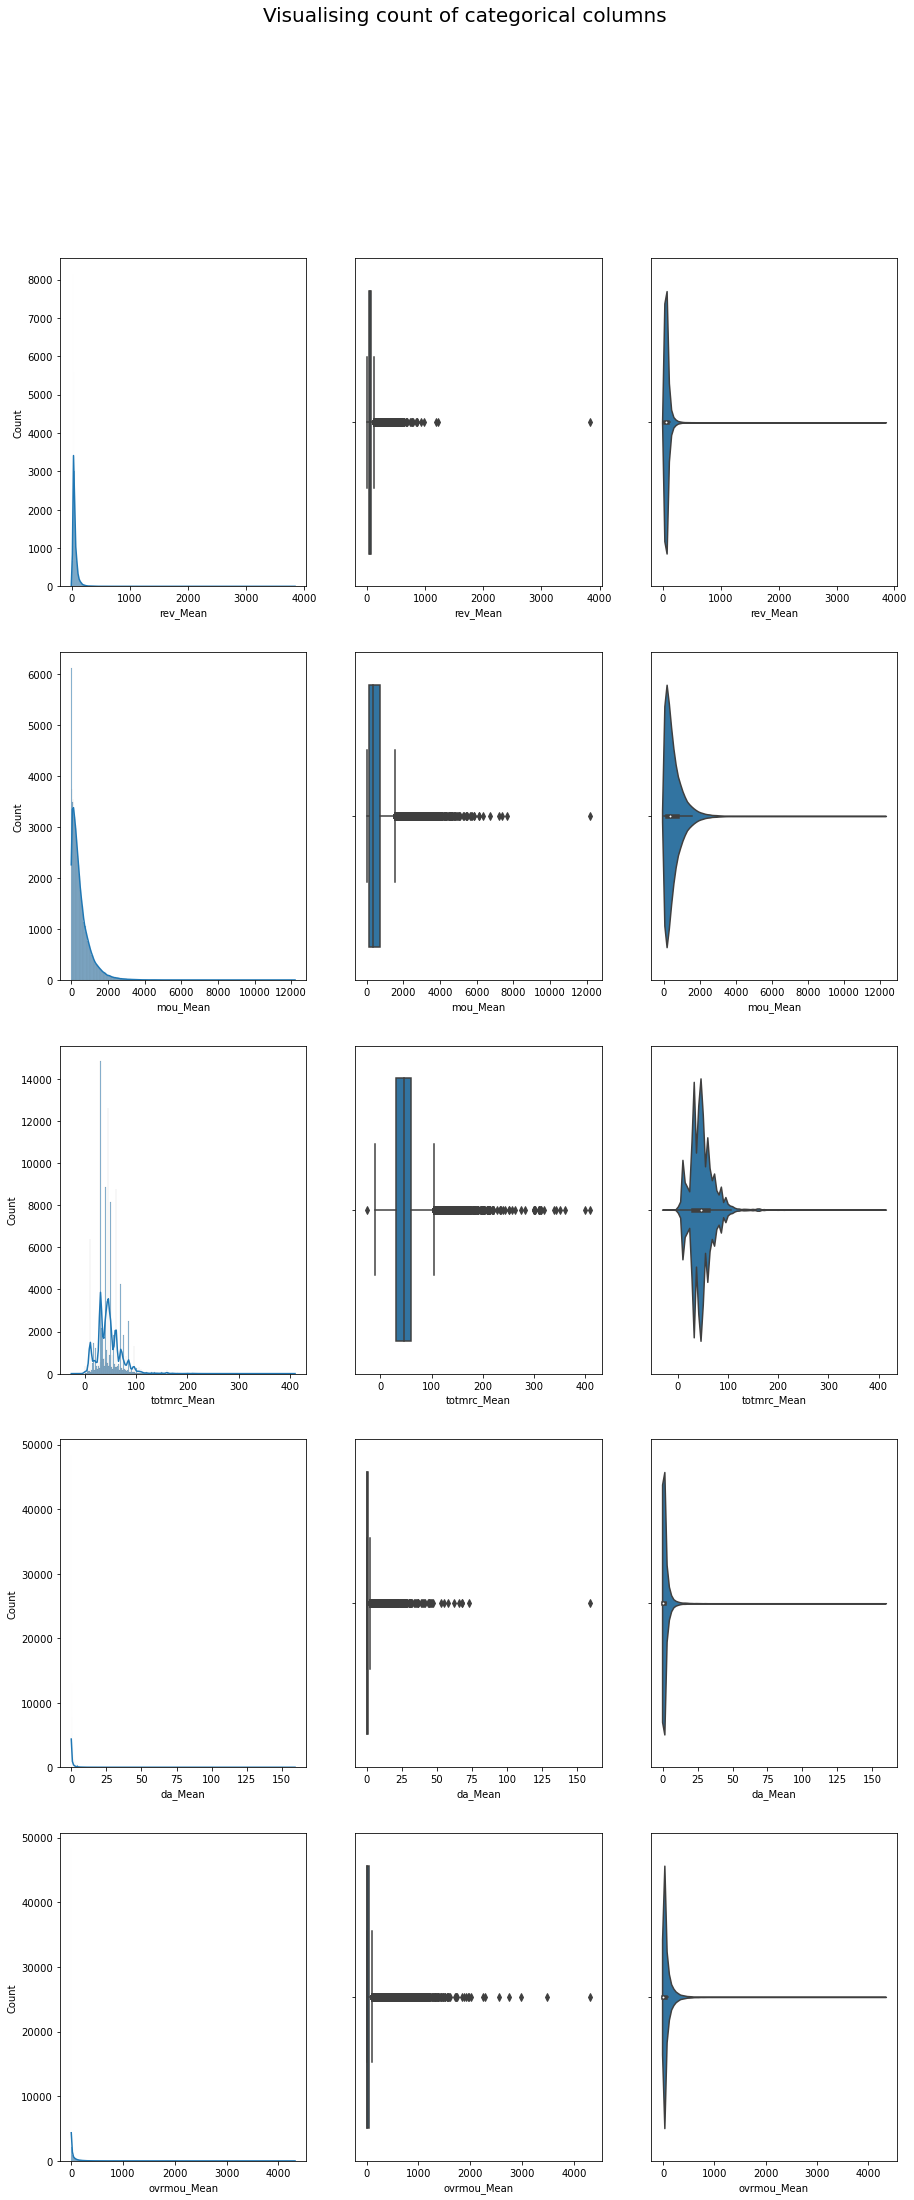

In [85]:
fig, ax = plt.subplots(5, 3, figsize=(15, 35))
for index, column in enumerate(num_cols):
    plt.suptitle("Visualising count of categorical columns", size=20)
    sns.histplot(data[column], ax=ax[index, 0], kde=True)
    sns.boxplot(data=data, x=column, ax=ax[index, 1])
    sns.violinplot(data=data, x=column, ax=ax[index, 2])